In [54]:
from numpy import sin,cos,tan,arcsin,arccos,arctan
from numpy import radians
from numpy import pi
import numpy as np

In [55]:
def declination_angle(doy):
    """Declination angle
    
    Parameters
    ----------
    doy : int
      Julian day of the year
    
    Returns
    -------
    delta : double
      The angle, in radians
    """
    return 23.45 * radians(cos(2 * pi / 365 * (172 - doy)))

def hour_angle(hr):
    """Angle of the sun as a function of the time of day
    
    Parameters
    ----------
    hr : double
       Time, in a 24 hour clock in [0,24)
    
    Returns
    -------
    tau : angle in radians
    """
    return (hr + 12) * pi / 12.0

def solar_altitude(delta, phi, tau):
    """The solar altitude
    
    Parameters
    ----------
    delta : double
      Declination angle (radians)
    phi : double
      Latitude (radians)
    tau : hour angle (radians)
    
    Returns
    -------
    alpha : altitude (radians)
    """
    alpha = arcsin(  sin(delta)*sin(phi) + cos(delta)*cos(phi)*cos(tau)  )
    if alpha <= 0.25 * pi / 180:
        # sun is beyond the horizon
        alpha = 0.25 * pi / 180
    return alpha

def solar_azhimuth(delta, phi, tau):
    """The sun's azhimuth
    
    Parameters
    ----------
    delta : double
      Declination angle (radians)
    phi : double
      Latitude (radians)
    tau : hour angle (radians)
    
    Returns
    -------
    phi_sun : altitude (radians)
    """
    phisun = arctan(  -sin(tau) / (tan(delta) * cos(phi) - sin(phi) * cos(tau))  )
    if phisun >= 0 and -sin(tau) <= 0:
        phisun += pi
    elif phisun <= 0 and -sin(tau) >= 0:
        phisun += pi
    return phisun

def flat_geom(alpha, phisun):
    """Geometric reference factor for a flat surface.

    Parameters
    ----------    
    alpha : double
      solar altitude (radians)
    phisun : double
      sun's azhimuth (radians)
      
    Returns
    -------
    flat : geometric factor [-]
    """
    return cos(arctan(0)) * sin(alpha)  + sin(arctan(0)) * cos(alpha) * cos(phisun - 0)

def slope_geom(slope, aspect, alpha, phisun):
    """Geometric reference factor of a slope at a given aspect.
    
    Parameters
    ----------   
    slope : double or array_like
      Positive, down-dip slope [radians]
    aspect : double or array_like
      Dip direction, clockwise from N = 0 [radians]
    alpha : double
      solar altitude (radians)
    phisun : double
      sun's azhimuth (radians)
      
    Returns
    -------
    factor : double or array_like
      
    """
    return cos(slope)*sin(alpha) + sin(slope)*cos(alpha)*cos(phisun - aspect)
    

In [73]:
def geometric_radiation_factors(slope, aspect, doy, hr, lat):
    """Returns the geometric factor to multiply times a solar radiation to get a slope-aspect specific value
    
    Parameters
    ----------
    slope : double or array_like
      Positive, down-dip slope, $-grad z \dot \hat{n}^\perp$, 
      where $\hat{n}^\perp$ here refers to the projection of 
      the normal onto the x-y plane.
    aspect : double or array_like
      Angle of $\hat{n}^\perp$ in map-view, measured 
      clockwise from N = 0 [radians].
    doy : int
      Julian day of the year
    hr : double
      Hour of the day, in 24-hour clock [0,24)
    lat : double
      Latitude [degrees]
      
    Returns
    -------
    Rslope : double or array_like
      Fraction of the full incident sun on a slope.
    Rflat : double or array_like
      Fraction of the full incident sun on a flat surface.
    """
    # check inputs
    assert(365 >= doy > 0 )
    assert(24 > hr >= 0)
    assert(90 >= lat >= -90)
    
    if type(slope) is np.ndarray:
        assert(slope.min() >= 0)
    else:
        assert(slope >= 0)

    if type(aspect) is np.ndarray:
        assert(360 > aspect.max())
        assert(aspect.min() >= 0)
    else:
        assert(360 > aspect >= 0)
    
    aspect_r = radians(aspect)
    slope_r = arctan(slope)
    
    delta = declination_angle(doy)
    tau = hour_angle(hr)
    phi = radians(lat)
    
    alpha = solar_altitude(delta,phi,tau)
    phi_sun = solar_azhimuth(delta,phi,tau)
    
    Rflat = flat_geom(alpha, phi_sun)
    Rslope = slope_geom(slope_r, aspect_r, alpha, phi_sun)
    return Rslope, Rflat

def geometric_ratio(*args, **kwargs):
    """Returns the geometric factor to multiply times a solar radiation to get a slope-aspect specific value
    
    Parameters
    ----------
    slope : double or array_like
      Positive, down-dip slope, $-grad z \dot \hat{n}^\perp$, 
      where $\hat{n}^\perp$ here refers to the projection of 
      the normal onto the x-y plane.
    aspect : double or array_like
      Angle of $\hat{n}^\perp$ in map-view, measured 
      clockwise from N = 0 [radians].
    doy : int
      Julian day of the year
    hr : double
      Hour of the day, in 24-hour clock [0,24)
    lat : double
      Latitude [degrees]
      
    Returns
    -------
    Rslope : double or array_like
      Fraction of the full incident sun on a slope.
    Rflat : double or array_like
      Fraction of the full incident sun on a flat surface.
    """    
    Rslope, Rflat = geometric_radiation_factors(*args, **kwargs)
    fac = Rslope / Rflat
    if type(fac) is np.ndarray:
        fac[fac > 6.] = 6.
        fac[fac < 0.] = 0.
    else:
        if fac > 6.:
            fac = 6.
        elif fac < 0.:
            fac = 0.
    return fac
    

In [74]:
def radiation_nogeom(clearsky_turbidity, alpha):
    """Radiation, independent of geometry"""
    solar_constant = 1366.67   
    return solar_constant * np.exp( -clearsky_turbidity * (0.128 - 0.054 * np.log10(1.0 / sin(alpha))) / sin(alpha) )


def radiation(slope, aspect, doy, hr, lat, clearsky_turbidity=2.0):
    delta = declination_angle(doy)
    tau = hour_angle(hr)
    phi = radians(lat)
    
    alpha = solar_altitude(delta,phi,tau)
    qSW_sun = radiation_nogeom(clearsky_turbidity, alpha)
    f_slope, f_flat = geometric_radiation_factors(slope, aspect, doy, hr, lat)
    fac = f_slope / f_flat
    
    if type(fac) is np.ndarray:
        fac[fac > 6.] = 6.
        fac[fac < 0.] = 0.
    else:
        if fac > 6.:
            fac = 6.
        elif fac < 0.:
            fac = 0.
        
    return qSW_sun * f_flat * fac

In [75]:
from matplotlib import pyplot as plt
import numpy as np

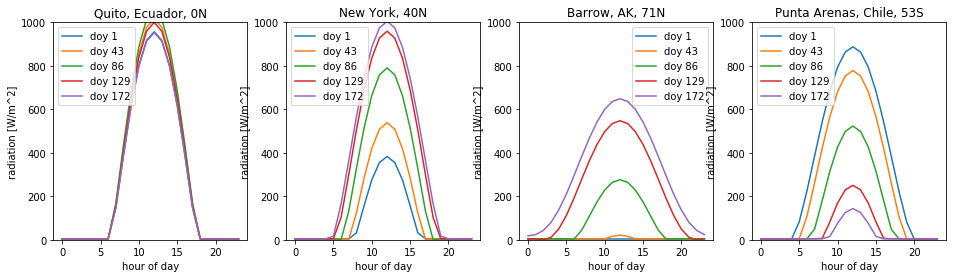

In [86]:
# plot the variation of Rflat as a function of hr on a couple days
def plot(lat, label, ax):
    days = [1, 172/4, 172/2, 172*3/4, 172]
    hrs = range(0,24)
    for day in days:
        rflat = np.array([radiation(0,0,day,hr,lat) for hr in hrs])
        ax.plot(hrs, rflat, label='doy {}'.format(day))

    ax.set_ylabel('radiation [W/m^2]')
    ax.set_xlabel('hour of day')
    ax.set_title(label)
    ax.set_ylim([0,1000])
    ax.legend()


fig = plt.figure(figsize=(16,4))
plot(0, 'Quito, Ecuador, 0N', fig.add_subplot(141))
plot(40, 'New York, 40N', fig.add_subplot(142))
plot(71, 'Barrow, AK, 71N', fig.add_subplot(143))
plot(-53, 'Punta Arenas, Chile, 53S', fig.add_subplot(144))


Text(0.5,1,u'at noon')

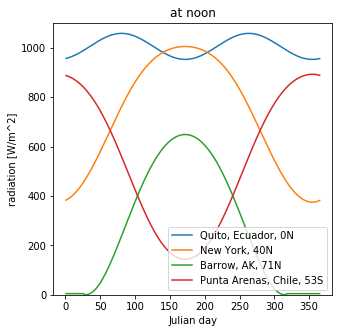

In [89]:
# Plot the variation with DoY at noon
def plot(lat, label, ax):
    days = range(1,366)
    hr = 12
    rflat = np.array([radiation(0,0,day,hr,lat) for day in days])
    ax.plot(days, rflat, label=label)

    ax.set_ylabel('radiation [W/m^2]')
    ax.set_xlabel('Julian day')
    ax.set_ylim([0,1100])
    
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
plot(0, 'Quito, Ecuador, 0N', ax)
plot(40, 'New York, 40N', ax)
plot(71, 'Barrow, AK, 71N', ax)
plot(-53, 'Punta Arenas, Chile, 53S', ax)
ax.legend()
ax.set_title('at noon')


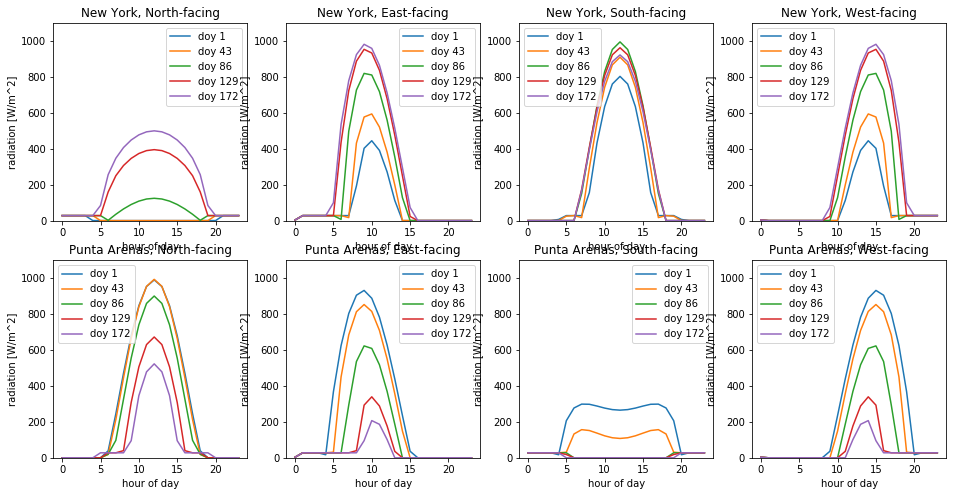

In [93]:
# as a function of aspect
slope = 1

# plot the variation of Rflat as a function of hr on a couple days
def plot(lat, aspect, label, ax):
    days = [1, 172/4, 172/2, 172*3/4, 172]
    hrs = range(0,24)
    for day in days:
        rflat = np.array([radiation(slope, aspect, day, hr, lat) for hr in hrs])
        ax.plot(hrs, rflat, label='doy {}'.format(day))

    ax.set_ylabel('radiation [W/m^2]')
    ax.set_xlabel('hour of day')
    ax.set_title(label)
    ax.set_ylim([0,1100])
    ax.legend()


fig = plt.figure(figsize=(16,8))
aspects = [0,90,180,270]
cardinals = ['North', 'East', 'South', 'West']

for i, (aspect, card) in enumerate(zip(aspects, cardinals)):
    plot(40, aspect, 'New York, {}-facing'.format(card), fig.add_subplot(2,4,i+1))
    plot(-53, aspect, 'Punta Arenas, {}-facing'.format(card), fig.add_subplot(2,4,i+1+4))

plt.show()



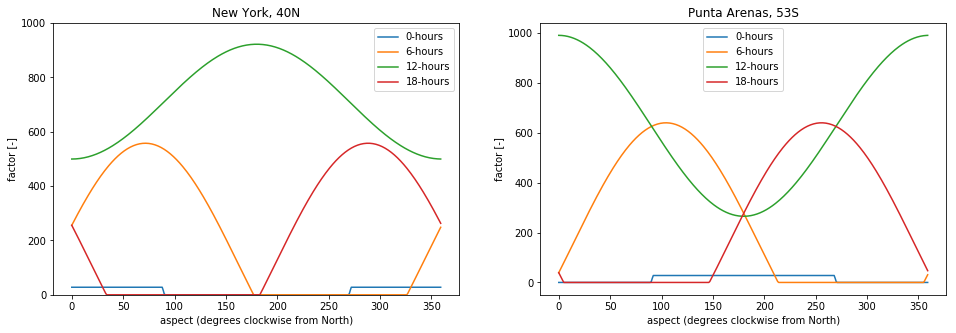

In [96]:
# wow that's hard to understand, let's try simpler
lat = 40
slope = 1
aspects = np.array(range(360))
doy = 172 # summer

hrs = [0,6,12,18]

fig = plt.figure(figsize=(16,5))

# NYC
ax = fig.add_subplot(121)
for hr in hrs:
    fac = radiation(slope, aspects, doy, hr, lat)
    ax.plot(aspects, fac, label='{}-hours'.format(hr))

ax.set_ylabel('factor [-]')
ax.set_xlabel('aspect (degrees clockwise from North)')
ax.set_ylim([0,1000])
ax.set_title("New York, 40N")
ax.legend()

# punta arenas
ax = fig.add_subplot(122)
lat = -53
doy = 1 # also summer
for hr in hrs:
    fac = radiation(slope, aspects, doy, hr, lat)
    ax.plot(aspects, fac, label='{}-hours'.format(hr))

ax.set_ylabel('factor [-]')
ax.set_xlabel('aspect (degrees clockwise from North)')
#ax.set_ylim([0,1])
ax.set_title("Punta Arenas, 53S")
ax.legend()

plt.show()
    
    


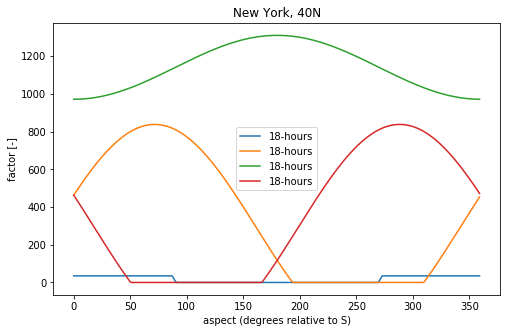

In [97]:
lat = 40
slope = .5
aspects = np.array(range(0,360))
doy = 172 # summer

fig = plt.figure(figsize=(8,5))

# NYC
ax = fig.add_subplot(111)
fac = np.array([radiation(slope, aspect, 172, 0, lat, 0.2) for aspect in aspects])
ax.plot(aspects, fac, label='{}-hours'.format(hr))

fac = np.array([radiation(slope, aspect, 172, 6, lat, 0.2) for aspect in aspects])
ax.plot(aspects, fac, label='{}-hours'.format(hr))

fac = np.array([radiation(slope, aspect, 172, 12, lat, 0.2) for aspect in aspects])
ax.plot(aspects, fac, label='{}-hours'.format(hr))

fac = np.array([radiation(slope, aspect, 172, 18, lat, 0.2) for aspect in aspects])
ax.plot(aspects, fac, label='{}-hours'.format(hr))

ax.set_ylabel('factor [-]')
ax.set_xlabel('aspect (degrees relative to S)')
#ax.set_ylim([0,1])
ax.set_title("New York, 40N")
ax.legend()


In [133]:
# Key question: is the average of the incident radiation on a hillslope 
# the same as the average of the incident radiation on a flat slope times 
# the average of the hillslope factor?  If so, we can use daily average qSWin from a Met 
# station and multiply by the hillslope factor.  If not, we might need to
# think about how we do the averaging to avoid needing daily-resolved
# solutions.

def daily_avg1(slope, aspect, doy, lat):
    hrs = range(24)
    return np.array([radiation(slope, aspect, doy, hr, lat) for hr in hrs]).mean()

def daily_avg_fac_hour(hr):
    def daily_avg_fac_(slope, aspect, doy, lat):
        daily_avg_flat = daily_avg1(0,0,doy,lat)

        avg_fac = geometric_ratio(slope, aspect, doy, hr, lat)
        return daily_avg_flat * avg_fac
    return daily_avg_fac_


def daily_avg_fac_avg(slope, aspect, doy, lat):
    daily_avg_flat = daily_avg1(0,0,doy,lat)

    hrs = range(24)
    avg_fac = np.array([geometric_ratio(slope, aspect, doy, hr, lat) for hr in hrs]).mean()
    return daily_avg_flat * avg_fac

def daily_avg_fac_max(slope, aspect, doy, lat):
    daily_avg_flat = daily_avg1(0,0,doy,lat)

    hrs = range(24)
    max_fac = np.array([geometric_ratio(slope, aspect, doy, hr, lat) for hr in hrs]).max()
    return daily_avg_flat * max_fac

def daily_avg_fac_avg2(slope, aspect, doy, lat):
    daily_avg_flat = daily_avg1(0,0,doy,lat)

    hrs = range(24)
    avg_facs = np.array([geometric_radiation_factors(slope, aspect, doy, hr, lat) for hr in hrs]).mean(axis=0)
    assert(avg_facs.shape[0] == 2)
    fac = avg_facs[0] / avg_facs[1]
    if fac > 6:
        fac = 6
    elif fac < 0:
        fac = 0
    
    return daily_avg_flat * fac



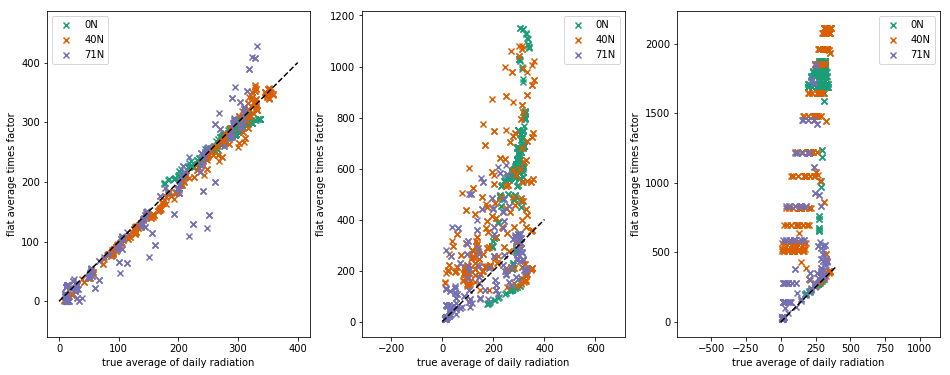

In [134]:
# Equator, New York, Barrow
lats = [0,40,71]
slopes = [0.05, 0.5]
aspects = np.array(range(0,360,30))
doys = np.array(range(0,365,30))+1

import matplotlib.colors as mpc
colors=['#1b9e77','#d95f02','#7570b3']

def plot(avg_func, ax):
    for i,lat in enumerate(lats):
        for k, doy in enumerate(doys):
            for j, slope in enumerate(slopes):
                avg1 = np.array([daily_avg1(slope, asp, doy, lat) for asp in aspects])
                avg2 = np.array([avg_func(slope, asp, doy, lat) for asp in aspects])
                dat = ax.scatter(avg1, avg2, marker='x', color=colors[i])
        dat.set_label('{}N'.format(lat))
    ax.legend()
    ax.plot([0,400], [0,400],'k--')
    ax.set_xlabel('true average of daily radiation')
    ax.set_ylabel('flat average times factor')
    plt.axis('equal')
    
    
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(131)
plot(daily_avg_fac_hour(12), ax)

ax = fig.add_subplot(132)
plot(daily_avg_fac_avg, ax)

ax = fig.add_subplot(133)
plot(daily_avg_fac_max, ax)


        
plt.show()        






In [ ]:
!jupyter nbconvert solar_radiation --to latex --post pdf